In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from matplotlib import pyplot as plt
from skimage.morphology import extrema
from skimage.segmentation import watershed
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   └── MyDrive
│       ├── brain_tumor
│       ├── brain_tumor_dataset
│       │   ├── test
│       │   │   ├── no
│       │   │   └── yes
│       │   └── train
│       │       ├── no
│       │       ├── TEST
│       │       │   ├── NO
│       │       │   └── YES
│       │       ├── TEST_CROP
│       │       │   ├── NO
│       │       │   └── YES
│       │       ├── TRAIN
│       │       │   ├── NO
│       │       │   └── YES
│       │       ├── TRAIN_CROP
│       │       │   ├── NO
│       │       │   └── YES
│       │       ├── VAL
│       │       │   ├── NO
│       │       │   └── YES
│       │       ├── VAL_CROP
│       │       │   ├── NO
│       │       │   └── YES
│       │       └── yes
│       └── Colab Notebooks
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

39 directories


In [ ]:
def ShowImage(title,img,ctype):
    plt.figure(figsize=(10, 10))
    if ctype=='bgr':
        b,g,r = cv2.split(img)       # get b,g,r
        rgb_img = cv2.merge([r,g,b])     # switch it to rgb
        plt.imshow(rgb_img)
    elif ctype=='hsv':
        rgb = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
        plt.imshow(rgb)
    elif ctype=='gray':
        plt.imshow(img,cmap='gray')
    elif ctype=='rgb':
        plt.imshow(img)
    else:
        raise Exception("Unknown colour type")
    plt.axis('off')
    plt.title(title)
    plt.show()

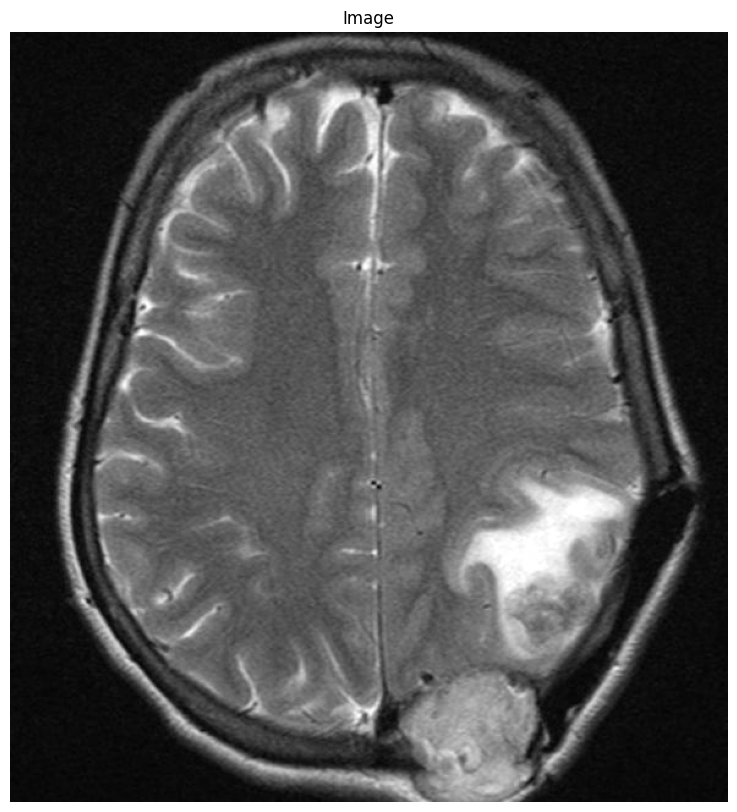

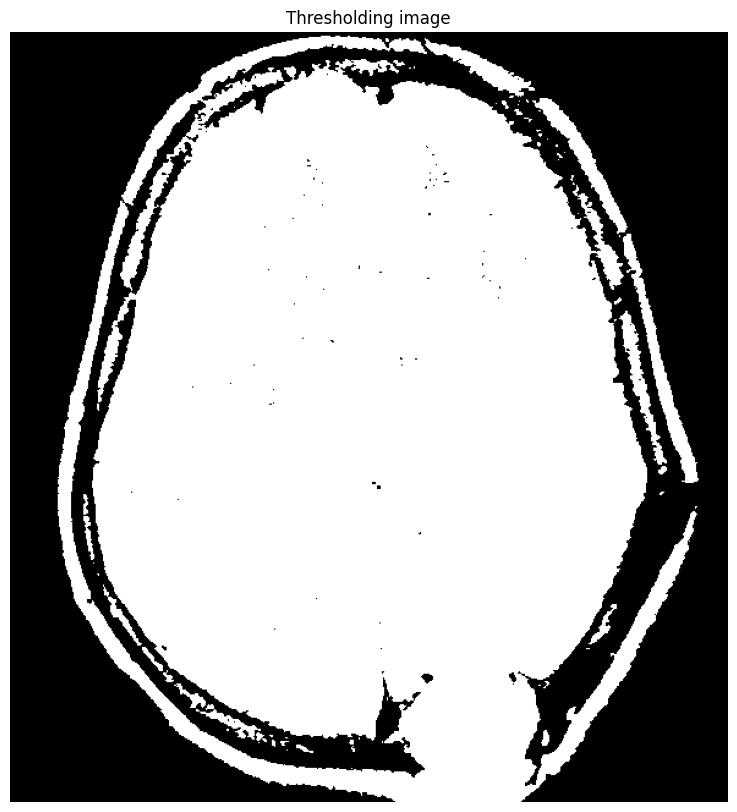

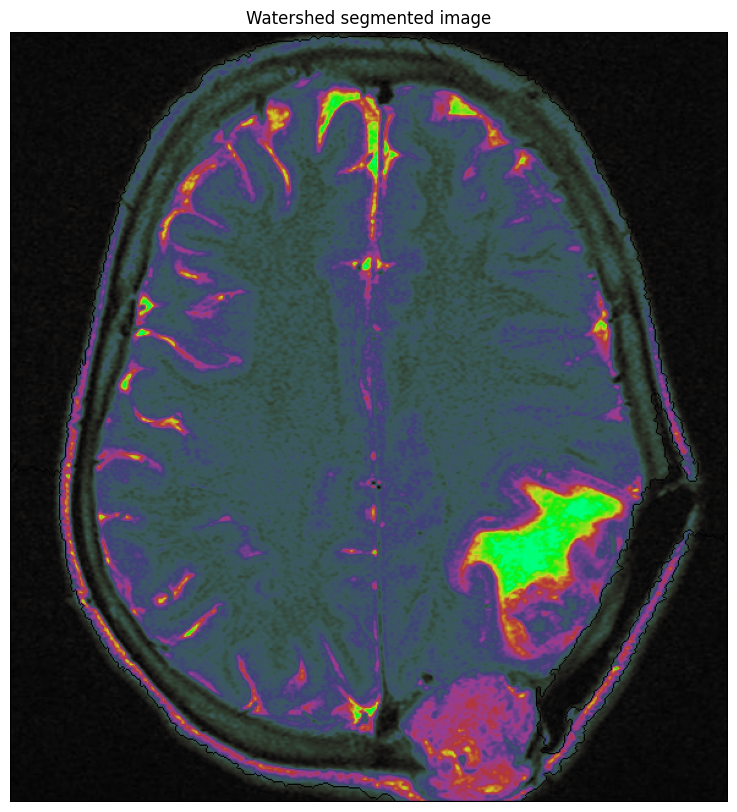

In [ ]:
img = cv2.imread("/content/drive/MyDrive/brain_tumor_dataset/test/yes/Y102.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ShowImage('Image',gray,'gray')

ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ShowImage('Thresholding image',thresh,'gray')

ret, markers = cv2.connectedComponents(thresh)

marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0]
largest_component = np.argmax(marker_area)+1 #Add 1 since we dropped zero above
brain_mask = markers==largest_component

brain_out = img.copy()
brain_out[brain_mask==False] = (0,0,0)

img = cv2.imread("/content/drive/MyDrive/brain_tumor_dataset/test/yes/Y102.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
save_to_path="jpg/segmented.jpg"
cv2.imwrite(save_to_path, im1)
ShowImage('Watershed segmented image',im1,'gray')

In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
os.chdir('/content/drive/MyDrive/brain_tumor_dataset/train')

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/brain_tumor_dataset/train/'
TEST_DIR = '/content/drive/MyDrive/brain_tumor_dataset/test/'
VAL_DIR = '/content/drive/MyDrive/brain_tumor_dataset/test/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 8/8 [01:12<00:00,  9.02s/it]
<ipython-input-7-59831cb31691>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



265 images loaded from /content/drive/MyDrive/brain_tumor_dataset/train/ directory.


100%|██████████| 2/2 [01:00<00:00, 30.45s/it]


253 images loaded from /content/drive/MyDrive/brain_tumor_dataset/test/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

253 images loaded from /content/drive/MyDrive/brain_tumor_dataset/test/ directory.


In [ ]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [ ]:
def split_data(X, y, test_size=0.2):

    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [ ]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [ ]:
img = cv2.imread('/content/drive/MyDrive/brain_tumor_dataset/test/yes/Y102.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

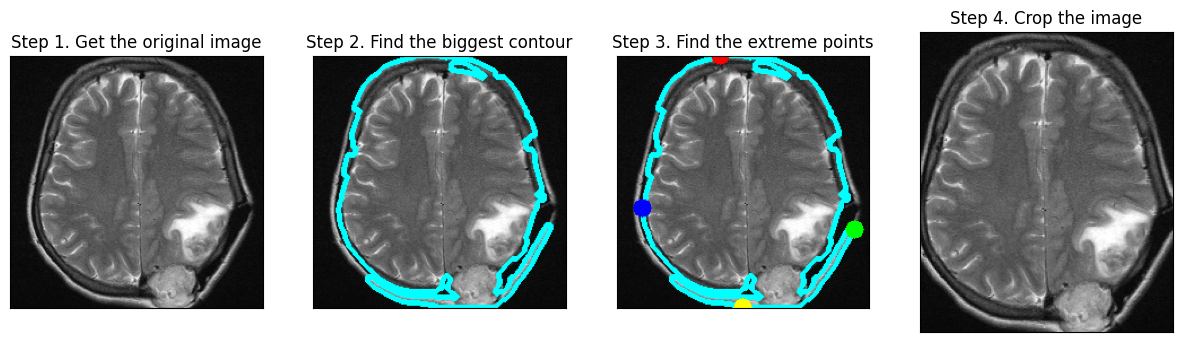

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them.
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
%cd /content/drive/MyDrive/brain_tumor/

/content/drive/MyDrive/brain_tumor


In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
!rm -rf preview/

In [ ]:
%cd /content/drive/MyDrive/brain_tumor

/content/drive/MyDrive/brain_tumor


In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/brain_tumor_dataset/train/TRAIN_CROP"
VAL_DIR = "/content/drive/MyDrive/brain_tumor_dataset/train/VAL_CROP"

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


In [ ]:
# load base model
vgg16_weight_path = '/content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
EPOCHS = 10
es = EarlyStopping(
    monitor='val_acc',
    mode='max',
    patience=6
)
train_set = train_datagen.flow_from_directory(TRAIN_DIR,target_size=(224, 224),batch_size=32,class_mode='categorical',color_mode='grayscale')

test_set = test_datagen.flow_from_directory(VAL_DIR,target_size=(224, 224),batch_size=32,class_mode='categorical',color_mode='grayscale')
batch_size=10

#steps_per_epoch = len(train_set)//batch_size
validation_steps = len(test_set)//batch_size # if you have validation data
history = model.fit_generator(
    train_generator,
    #steps_per_epoch=10,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


<ipython-input-26-86bcc23aa37f>:14: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 10.7141 - accuracy: 0.6364

8/8 [==============================] - 227s 29s/step - loss: 10.7141 - accuracy: 0.6364 - val_loss: 2.2013 - val_accuracy: 0.8142
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 4.9933 - accuracy: 0.7036

8/8 [==============================] - 5s 569ms/step - loss: 4.9933 - accuracy: 0.7036
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 4.0914 - accuracy: 0.7510

8/8 [==============================] - 5s 572ms/step - loss: 4.0914 - accuracy: 0.7510
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss: 2.5316 - accuracy: 0.8103

8/8 [==============================] - 6s 731ms/step - loss: 2.5316 - accuracy: 0.8103
Epoch 5/10
8/8 [==============================] - ETA: 0s - loss: 3.5710 - accuracy: 0.7787

8/8 [==============================] - 5s 558ms/step - loss: 3.5710 - accuracy: 0.7787
Epoch 6/10
8/8 [==============================] - ETA: 0s - loss: 2.1672 - accuracy: 0.8458

8/8 [==============================] - 5s 607ms/step - loss: 2.1672 - accuracy: 0.8458
Epoch 7/10
8/8 [==============================] - ETA: 0s - loss: 3.7621 - accuracy: 0.7747

8/8 [==============================] - 6s 654ms/step - loss: 3.7621 - accuracy: 0.7747
Epoch 8/10
8/8 [==============================] - ETA: 0s - loss: 2.4985 - accuracy: 0.8261

8/8 [==============================] - 4s 542ms/step - loss: 2.4985 - accuracy: 0.8261
Epoch 9/10
8/8 [==============================] - ETA: 0s - loss: 1.8975 - accuracy: 0.8458

8/8 [==============================] - 6s 704ms/step - loss: 1.8975 - accuracy: 0.8458
Epoch 10/10
8/8 [==============================] - ETA: 0s - loss: 1.9935 - accuracy: 0.8419

8/8 [==============================] - 5s 578ms/step - loss: 1.9935 - accuracy: 0.8419


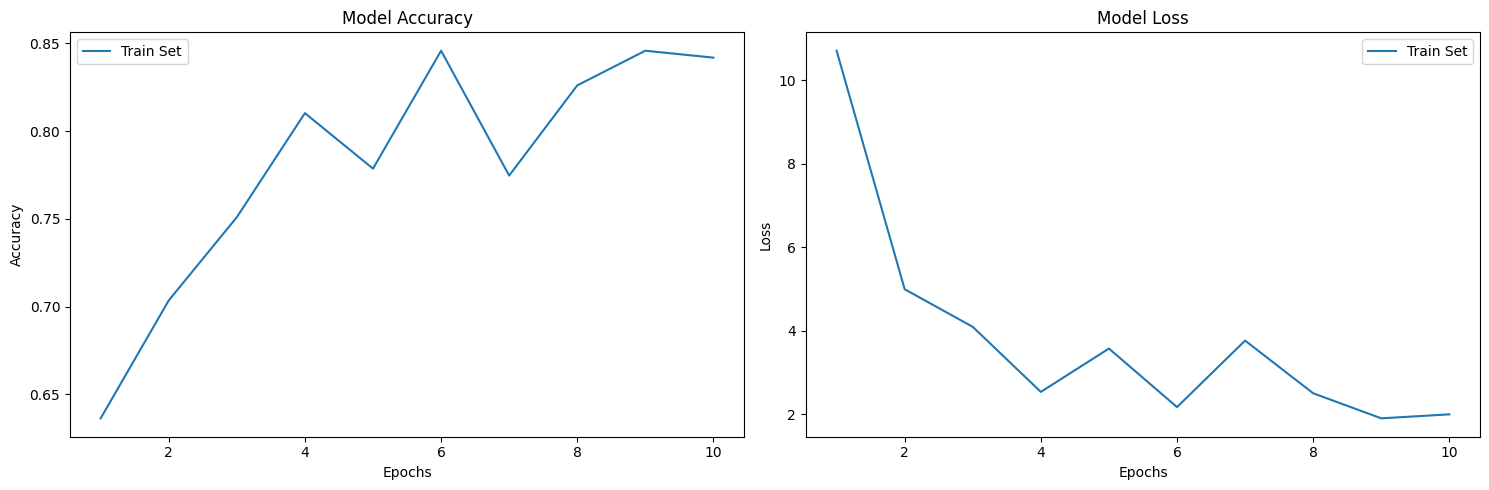

In [ ]:
# plot model performance
acc = history.history['accuracy']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
#plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
#plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# clean up the space
# !rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model
model.save('fusion_VGG_model.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,validation_split=0.22)
training_set = datagen.flow_from_directory('/content/drive/MyDrive/brain_tumor_dataset/train/TRAIN_CROP',
                                            target_size=(224,224),
                                            color_mode="rgb",
                                            subset="training",
                                            class_mode="binary",
                                            batch_size=32,
                                            shuffle=True)


Found 198 images belonging to 2 classes.


In [ ]:
valid_generator=datagen.flow_from_directory( directory="/content/drive/MyDrive/brain_tumor_dataset/train/TRAIN_CROP",
                                                target_size=(224,224),
                                                color_mode="rgb",
                                                subset="validation",
                                                class_mode="binary",
                                                batch_size=32,
                                                shuffle=True)


Found 55 images belonging to 2 classes.


In [ ]:
## showing some image from training
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

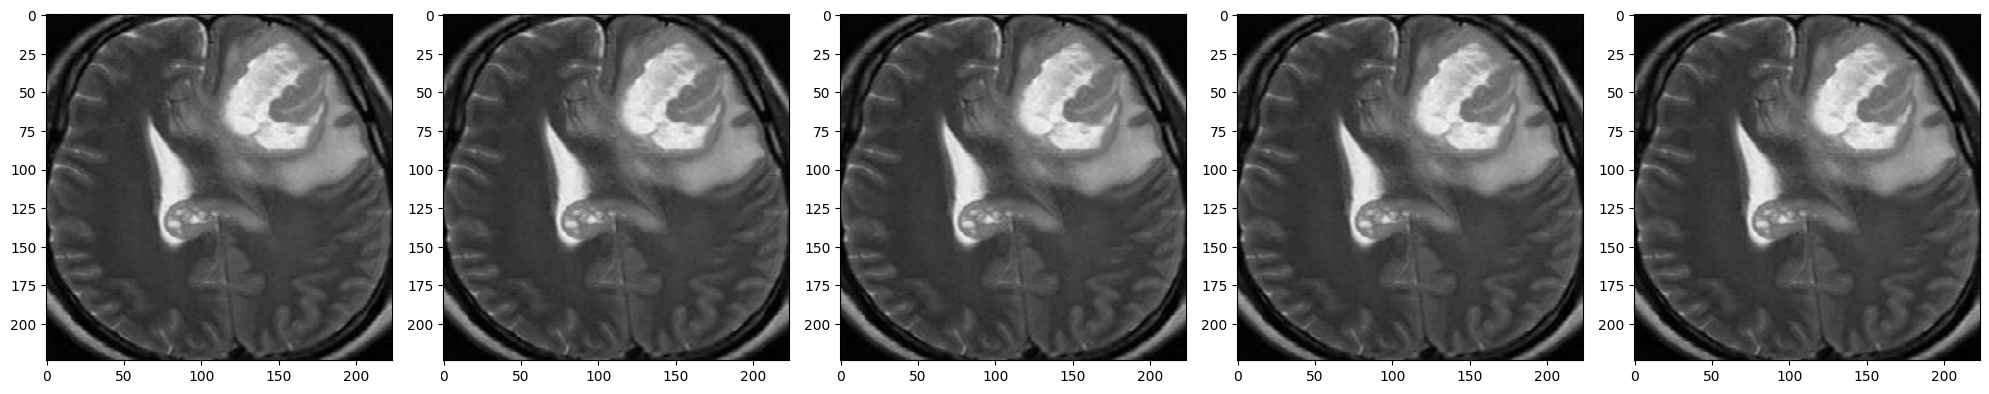

In [ ]:
images = [training_set[0][0][0] for i in range(5)]
plotImages(images)

In [ ]:
training_set.class_indices

{'NO': 0, 'YES': 1}

In [ ]:
import cv2
import os
import sklearn
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


%matplotlib inline

In [ ]:
# Base path and labels
base_path = '/content/drive/MyDrive/brain_tumor_dataset/train'
class_names = ['NO','YES']

In [ ]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 12
VERBOSE = 1

In [ ]:
x_train=[]
y_train=[]

# Loading Training Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path,'/content/drive/MyDrive/brain_tumor_dataset/train/TRAIN_CROP'),i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Loading Testing Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path, '/content/drive/MyDrive/brain_tumor_dataset/train/TEST_CROP'), i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Testing dataset Loading complete.')

x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

100%|██████████████████████████████| 155/155 [00:00<00:00, 220.91it/s]


Training dataset Loading complete.


100%|███████████████████████████████| 155/155 [00:03<00:00, 45.66it/s]


Testing dataset Loading complete.


In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")

In [ ]:
history = model.fit(
    training_set,
    epochs=2,
    validation_data=valid_generator
    )

Epoch 1/2
7/7 [==============================] - 6s 979ms/step - loss: 0.5533 - accuracy: 0.7172 - val_loss: 0.4799 - val_accuracy: 0.8364
Epoch 2/2
7/7 [==============================] - 2s 223ms/step - loss: 0.5735 - accuracy: 0.6919 - val_loss: 0.5195 - val_accuracy: 0.7091


(257, 212, 3)


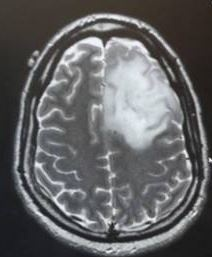

1/1 [==============================] - 1s 720ms/step
BrainTumor 


In [ ]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
image = cv2.imread('/content/drive/MyDrive/brain_tumor_dataset/train/TEST_CROP/YES/106.jpg')
print(image.shape)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
from tensorflow.keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/brain_tumor_dataset/train/TEST_CROP/YES/106.jpg', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image=test_image/255
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
result
if result[0]<=0.8:
  print("test result: the person has ")
  print("No BrainTumor")
else:
    print("BrainTumor ")
